In [1]:
#!pip install -U segmentation-models-pytorch albumentations --user
from typing import List
import cv2
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils as smp_utils
import os
import random

from torchvision.transforms import v2
import torchvision.transforms.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import colors, pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

c:\Users\ivan\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

In [2]:
dataset_path = 'data/'
images_path = dataset_path + 'images/'
labels_path = dataset_path + 'labels/'

images = sorted([images_path + filename for filename in os.listdir(images_path)])
labels = sorted([labels_path + filename for filename in os.listdir(labels_path)])

images_train, images_val, labels_train, labels_val = train_test_split(images, labels, train_size=0.85, shuffle=True)
print(len(images_train), len(images_val), len(labels_train), len(labels_val))

44 8 44 8


In [3]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=False):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(self.images[idx]).convert("RGB"))
        label = np.array(Image.open(self.labels[idx]).convert("L"), dtype=np.float32)

        #to tensore
        image = TF.to_tensor(image)
        label = TF.to_tensor(label)

        if self.transform:
            #random crop
            i, j, h, w = transforms.RandomResizedCrop.get_params(image, scale=(512,512), ratio=(0.5,1.0))
            image = TF.resized_crop(image, i, j, h, w, (512, 512))
            label = TF.resized_crop(label, i, j, h, w, (512, 512))

            #hor flip
            if random.random() > 0.5:
                image = TF.hflip(image)
                label = TF.hflip(label)

            #ver flip
            if random.random() > 0.5:
                image = TF.vflip(image)
                label = TF.vflip(label)

            #rotation
            angle = random.uniform(-45.0, 45.0)
            image = TF.rotate(image, angle)
            label = TF.rotate(label, angle)
        else:
            resize = transforms.Resize((512, 512))
            image = resize(image)
            label = resize(label)

        return image, label / 255.0

In [4]:
transform_train = v2.Compose([
    v2.ToTensor(),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ConvertImageDtype(dtype=torch.float32),
    v2.RandomResizedCrop(size=(512, 512), scale=(0.5, 1.0)),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),   
])

transform_val = v2.Compose([
    v2.ToTensor(),
    #v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    v2.ConvertImageDtype(dtype=torch.float32),
    v2.Resize((512, 512)),
])

In [5]:
train_dataset = CustomDataset(images_train, labels_train, transform=True)
val_dataset = CustomDataset(images_val, labels_val, transform=False)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
import matplotlib.pyplot as plt
def show_tensor_images(train_tensor, val_tensor):
    train_image = train_tensor.permute(1, 2, 0).numpy()
    val_image = val_tensor.permute(1, 2, 0).numpy()
    train_image = np.clip(train_image, 0, 1)
    val_image = np.clip(val_image, 0, 1)

    _, axs = plt.subplots(1, 2, figsize=(12, 6))
    
    axs[0].imshow(train_image)
    axs[0].set_title('Training Image')
    axs[0].axis('off')

    axs[1].imshow(val_image)
    axs[1].set_title('Validation Image')
    axs[1].axis('off')

    plt.show()

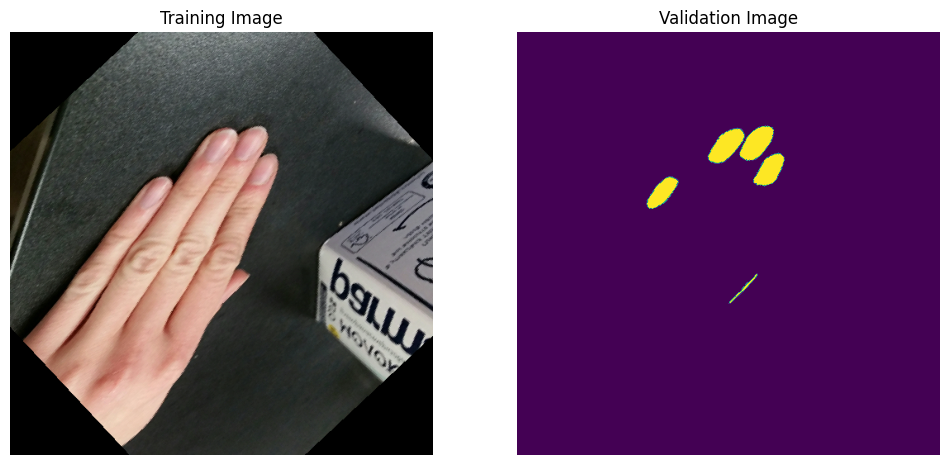

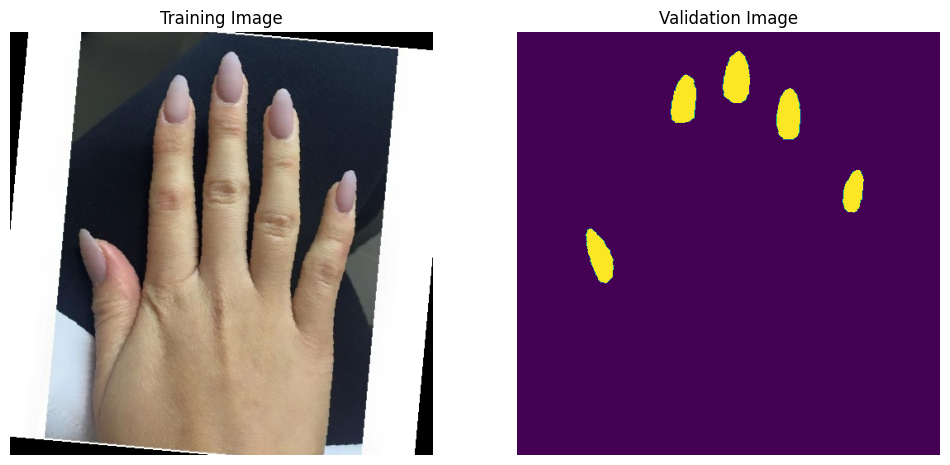

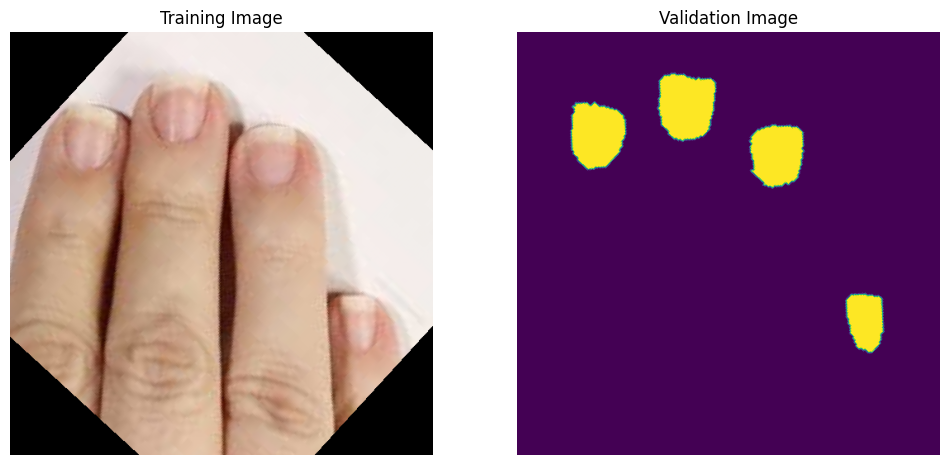

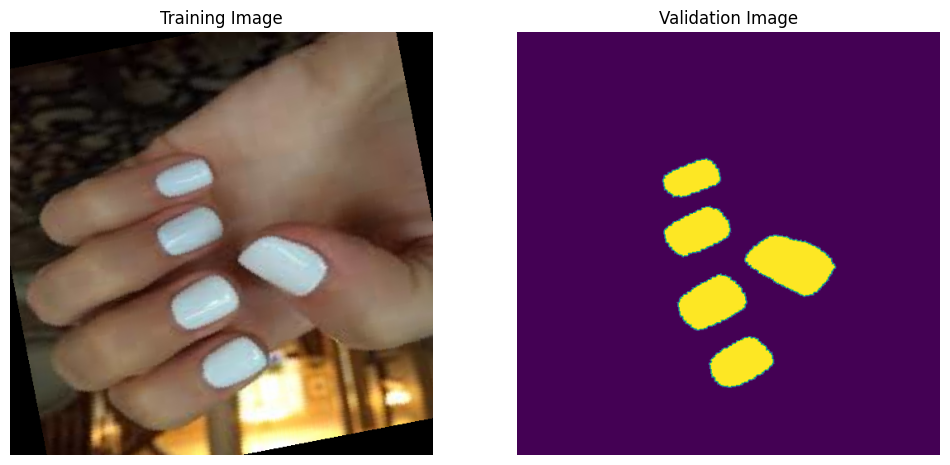

In [7]:
for i, m in train_dataloader:
    for im, la in zip(i, m):
        show_tensor_images(im, la)
    break

## Model

In [8]:
model = smp.Unet(
    encoder_name = 'resnet18',
    encoder_weights = 'imagenet',
    classes = 1,
    activation = 'sigmoid',
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
device

'cuda'

In [9]:
loss = smp_utils.losses.BCELoss() #smp_utils.losses.JaccardLoss() #smp_utils.losses.DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
metrics = [smp_utils.metrics.Accuracy(), smp_utils.metrics.Precision(), smp_utils.metrics.Recall(), smp_utils.metrics.Fscore(), smp_utils.metrics.IoU()]

In [10]:
train_epoch = smp_utils.train.TrainEpoch(
    model,
    loss = loss,
    metrics = metrics,
    optimizer = optimizer,
    device = device,
)

val_epoch = smp_utils.train.ValidEpoch(
    model,
    loss = loss,
    metrics = metrics,
    device = device,
)

train_epoch

## Training

In [11]:
save_path = 'weights/run_fixed6/'

In [12]:
epochs = 500
best_iou = 0
best_loss = 1e+9

for e in range(epochs):
    print(f'Epoch: {e + 1}')
    train_logs = train_epoch.run(train_dataloader)
    val_logs = val_epoch.run(val_dataloader)

    if best_iou < val_logs['iou_score']:
        best_iou = val_logs['iou_score']
        torch.save(model, save_path + 'best_iou.pth')
        log_best_iou = val_logs

    if best_loss > val_logs['bce_loss']:
        best_loss = val_logs['bce_loss']
        torch.save(model, save_path + 'best_loss.pth')
        log_best_loss = val_logs
torch.save(model, save_path + 'last_epoch.pth')
print('\n\n', log_best_iou)
print(log_best_loss)

Epoch: 1
valid: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s, bce_loss - 0.5516, accuracy - 0.8635, precision - 0.2288, recall - 0.8521, fscore - 0.3606, iou_score - 0.2202]
Epoch: 2
valid: 100%|██████████| 2/2 [00:00<00:00,  5.59it/s, bce_loss - 0.4555, accuracy - 0.9114, precision - 0.3279, recall - 0.8562, fscore - 0.4742, iou_score - 0.3108]
Epoch: 3
valid: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s, bce_loss - 0.3866, accuracy - 0.9244, precision - 0.3787, recall - 0.8652, fscore - 0.5243, iou_score - 0.3555]
Epoch: 4
valid: 100%|██████████| 2/2 [00:00<00:00,  5.52it/s, bce_loss - 0.3101, accuracy - 0.9534, precision - 0.5426, recall - 0.8282, fscore - 0.6491, iou_score - 0.4818]
Epoch: 5
valid: 100%|██████████| 2/2 [00:00<00:00,  5.64it/s, bce_loss - 0.2606, accuracy - 0.9682, precision - 0.6784, recall - 0.774, fscore - 0.7221, iou_score - 0.5654] 
Epoch: 6
valid: 100%|██████████| 2/2 [00:00<00:00,  5.85it/s, bce_loss - 0.2449, accuracy - 0.9683, precision - 0.6544, recall - 0

## Check result

In [12]:
model = torch.load(save_path + 'best_iou.pth')
#model = torch.load(save_path + 'last_epoch.pth')
#model = torch.load(save_path + 'best_loss.pth')

In [14]:
for i, (images, masks) in enumerate(val_dataloader):
    images = images.to(device)
    masks = masks.to(device)
    for j, (image, mask) in enumerate(zip(images, masks)):
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0).squeeze().squeeze()
        with torch.no_grad():
            output = torch.sigmoid(model(image)).squeeze().squeeze()
            output = (output - torch.min(output.cpu())) / (torch.max(output.cpu()) - torch.min(output.cpu()))
            output = (output > 0.5).float()#.squeeze().squeeze()
        print(torch.min(output.cpu()), torch.max(output.cpu()))
        concat = torch.cat((output, mask), dim=1)
        print(output.shape, mask.shape, concat.shape)
        torchvision.utils.save_image(concat, save_path + f"{i * batch_size + j}.png")
        #torchvision.utils.save_image(mask, save_path + f"{i * batch_size + j}_label.png")
        #torchvision.utils.save_image(output, save_path + f"{i * batch_size + j}_predict.png")

tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])
tensor(0.) tensor(1.)
torch.Size([512, 512]) torch.Size([512, 512]) torch.Size([512, 1024])


## Check another data

In [39]:
photo = sorted([dataset_path + 'qwerty/' + filename for filename in os.listdir(dataset_path + 'qwerty/')])
photo
photo_dataset = CustomDataset(photo, photo, False)

In [40]:
image, _ = photo_dataset.__getitem__(0)
image = image.to(device)
output = torch.sigmoid(model(image.unsqueeze(0))).squeeze().unsqueeze(0)
output = (output - torch.min(output.cpu())) / (torch.max(output.cpu()) - torch.min(output.cpu()))
output = (output > 0.5).float().repeat(3, 1, 1)
concat = torch.cat((output, image), dim=2)
torchvision.utils.save_image(concat, save_path + "A.png")